In [1]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region_name = boto3.Session().region_name

In [2]:
#variable to store all tables created
ingest_exploration_passed = False

In [3]:
#Retrieving stores database
%store -r ingest_create_athena_db_passed

In [4]:
#Checking for returned database
print(ingest_create_athena_db_passed)

True


In [5]:
#Retrieving stores tables
%store -r ingest_create_athena_table_csv_passed

In [6]:
print(ingest_create_athena_table_csv_passed)

True


In [7]:
#Retrieving stored private s3 bucket
%store -r s3_private_path_csv_credit_card_trans
%store -r s3_private_path_csv_user_credit_card_trans
%store -r s3_private_path_csv_card_info
%store -r s3_private_path_csv_user_info

In [8]:
#Checking bucket is returned
print(s3_private_path_csv_credit_card_trans)
print(s3_private_path_csv_user_credit_card_trans)
print(s3_private_path_csv_card_info)
print(s3_private_path_csv_user_info)

s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/credit_card_trans/
s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/user_credit_card_trans/
s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/card_info/
s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/user_info/


In [9]:
# Set athena database name and table names
database_name = "credit_card_fraud_db"
table_one_csv = "user_credit_card_trans"
table_two_csv = "credit_card_trans"
table_three_csv = "cards_info"
table_four_csv = "users_info"

In [10]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_directory = "s3://{0}/athena/staging".format(bucket)

In [11]:
#variable to store all joined tables
ingest_joined_athena_table_csv_passed = False

In [12]:
#Creating tables in database
!pip install pyathena
import pandas as pd
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from pyathena.pandas.util import as_pandas

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [13]:
conn = connect(region_name = region_name, s3_staging_dir = s3_staging_directory)

In [14]:
#Getting number of cards not on the dark web
card_on_dark_web = 'No'
statement = """SELECT COUNT(*) AS num_cards_dark FROM {}.{} 
            WHERE card_on_dark_web = '{}'""".format(database_name, table_three_csv, card_on_dark_web)

print(statement)

SELECT COUNT(*) AS num_cards_dark FROM credit_card_fraud_db.cards_info 
            WHERE card_on_dark_web = 'No'


In [15]:
no = pd.read_sql(statement, conn)
no

,num_cards_dark
0,6146


In [16]:
#creating dataframe with card information
df_cards_info = pd.read_sql('SELECT * FROM {}.{}'.format(database_name, table_three_csv), conn)

In [17]:
df_cards_info.head()

,user,card_index,card_brand,card_type,card_number,expires,cvv,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,0,0,Visa,Debit,None,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,None,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,None,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,None,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),None,03/2009,75,YES,1,$28,09/2008,2009,No


In [18]:
df_cards_info.dtypes

user                      int64
card_index                int64
card_brand               object
card_type                object
card_number              object
expires                  object
cvv                       int64
has_chip                 object
cards_issued              int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

## For cards_info, we can see that some variables have the wrong datatype.
card_number, expires, credit_limit, acct_open_date all have object datatype. we will adjust all these columns to to correct datatype. due to card_number not ingesting properly we will eliminate this column out of our dataframe, we also do not need it as it is not important to us.

In [19]:
#creating dataframe with user information
df_user_info = pd.read_sql('SELECT * FROM {}.{}'.format(database_name, table_four_csv), conn)

In [20]:
df_user_info.head()

,person,current_age,retirement_age,birth_year,birth_month,gender,address,apartment,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [21]:
#Setting index name to use as join for later
df_user_info.index.name = 'user'
df_user_info

,person,current_age,retirement_age,birth_year,birth_month,gender,address,apartment,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
user,,,,,,,,,,,,,,,,,,
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Jose Faraday,32,70,1987,7,Male,6577 Lexington Lane,9.0,Freeport,NY,11520,40.65,-73.58,$23550,$48010,$87837,703,3
1996,Ximena Richardson,62,65,1957,11,Female,2 Elm Drive,955.0,Independence,KY,41051,38.95,-84.54,$24218,$49378,$104480,740,4
1997,Annika Russell,47,67,1973,1,Female,276 Fifth Boulevard,NaN,Elizabeth,NJ,7201,40.66,-74.19,$15175,$30942,$71066,779,3


In [22]:
df_user_info.dtypes

person                        object
current_age                    int64
retirement_age                 int64
birth_year                     int64
birth_month                    int64
gender                        object
address                       object
apartment                    float64
city                          object
state                         object
zipcode                        int64
latitude                     float64
longitude                    float64
per_capita_income_zipcode     object
yearly_income_person          object
total_debt                    object
fico_score                     int64
num_credit_cards               int64
dtype: object

## For user_info, we can see that some variables have the wrong datatype.
total_debt, yearly_income_person, per_capita_income_zipcode,  all have object datatype. we will adjust all these columns to to correct datatype in preparation step. 

In [23]:
#creating dataframe with credit card transaction. Takes 30 seconds to execute at 100000 limit. Takes 2 minutes and 30 seconds for 500000 Limit. 
#we will create separate dataframe for yes and no frauds each 500000

df_no_card_trans = pd.read_sql("SELECT * FROM {}.{} WHERE is_fraud = 'No' LIMIT 250000".format(database_name, table_two_csv), conn)
df_yes_card_trans = pd.read_sql("SELECT * FROM {}.{} WHERE is_fraud = 'Yes' LIMIT 250000".format(database_name, table_two_csv), conn)

In [24]:
#Checking if query works for yes frauds
print(df_yes_card_trans.shape)
df_yes_card_trans.head()

(29737, 15)


,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,,NaN,5251,,Yes
1,1963,2,2013,12,2,08:35,$114.00,Online Transaction,1270471339275628505,ONLINE,,NaN,3730,,Yes
2,1963,2,2013,12,2,09:16,$173.15,Online Transaction,-4317138273541964845,ONLINE,,NaN,5211,,Yes
3,1963,2,2013,12,2,10:06,$243.57,Online Transaction,7035602569409149834,ONLINE,,NaN,5311,,Yes
4,1963,2,2013,12,2,10:13,$182.99,Online Transaction,3635551857898739641,ONLINE,,NaN,5310,,Yes


In [25]:
#Checking if query works for no frauds
print(df_no_card_trans.shape)
df_no_card_trans.head()

(250000, 15)


,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,787,0,2003,3,12,19:04,$-70.00,Swipe Transaction,1799189980464955940,Paragould,AR,72450.0,5499,,No
1,787,0,2003,3,12,19:11,$4.10,Swipe Transaction,1799189980464955940,Paragould,AR,72450.0,5499,,No
2,787,0,2003,3,12,19:26,$70.00,Swipe Transaction,1799189980464955940,Paragould,AR,72450.0,5499,,No
3,787,0,2003,3,13,10:45,$44.00,Swipe Transaction,-7016888828590848447,Paragould,AR,72450.0,7538,,No
4,787,0,2003,3,13,13:16,$115.98,Online Transaction,4241336128694185533,ONLINE,,NaN,4814,,No


In [26]:
#concating these two data together
df_credit_card_trans = pd.concat([df_yes_card_trans, df_no_card_trans])

In [27]:
df_credit_card_trans.head()

,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,,NaN,5251,,Yes
1,1963,2,2013,12,2,08:35,$114.00,Online Transaction,1270471339275628505,ONLINE,,NaN,3730,,Yes
2,1963,2,2013,12,2,09:16,$173.15,Online Transaction,-4317138273541964845,ONLINE,,NaN,5211,,Yes
3,1963,2,2013,12,2,10:06,$243.57,Online Transaction,7035602569409149834,ONLINE,,NaN,5311,,Yes
4,1963,2,2013,12,2,10:13,$182.99,Online Transaction,3635551857898739641,ONLINE,,NaN,5310,,Yes


In [28]:
fraud_count = df_credit_card_trans['is_fraud'].value_counts()
fraud_count

No     250000
Yes     29737
Name: is_fraud, dtype: int64

In [29]:
#looking at unique values for is_fraud
df_credit_card_trans['is_fraud'].unique()

array(['Yes', 'No'], dtype=object)

In [30]:
#checking shape of credit_card_trans
df_credit_card_trans.shape

(279737, 15)

### For credit_card_trans, we have a lot of empty values in error column. We will replace empty columns with NaN values, merchant name is in wrong data type, amount and time will also be adjust.

In [31]:
#creating dataframe with user credit card transaction
df_user_card_trans = pd.read_sql('SELECT * FROM {}.{}'.format(database_name, table_one_csv), conn)

In [32]:
df_user_card_trans.head()

,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,0,0,2014,5,5,06:50,$41.11,Swipe Transaction,-5475680618560174533,Monterey Park,CA,91755.0,5942,,No
1,0,0,2014,5,5,09:37,$57.76,Swipe Transaction,4055257078481058705,La Verne,CA,91750.0,7538,,No
2,0,0,2014,5,5,20:05,$206.37,Online Transaction,-2392212127717286832,ONLINE,,NaN,4899,,No
3,0,0,2014,5,7,21:35,$13.93,Swipe Transaction,-3265671264153192329,Monterey Park,CA,91754.0,7832,,No
4,0,0,2014,5,8,17:54,$6.96,Online Transaction,-521141999023077663,ONLINE,,NaN,5815,,No


In [33]:
df_user_card_trans.dtypes

user                int64
card                int64
year                int64
month               int64
day                 int64
time               object
amount             object
use_chip           object
merchant_name      object
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
is_fraud           object
dtype: object

In [34]:
#Getting shape of all dataframes
print('user_info :', df_user_info.shape)
print('cards_info :', df_cards_info.shape)
print('user_card_trans :', df_user_card_trans.shape)
print('credit_card_trans :', df_credit_card_trans.shape)

user_info : (2000, 18)
cards_info : (6146, 13)
user_card_trans : (19963, 15)
credit_card_trans : (279737, 15)


### For credit_card_trans, we have a lot of empty values in error column. We will replace empty columns with NaN values, merchant name is in wrong data type, amount and time will also be adjust.

In [35]:
#joining the three dataframes using pandas. This is a LEFT JOIN
df_cred_info = pd.merge(df_credit_card_trans, df_cards_info, how = 'left', on='user')

In [36]:
df_cred_info.head()

,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,...,card_type,card_number,expires,cvv,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,...,Credit,None,07/2014,123,YES,1,$18700,11/2000,2010,No
1,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,...,Debit,None,02/2011,650,YES,1,$8420,11/2008,2012,No
2,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,...,Debit (Prepaid),None,10/2022,56,YES,1,$35,10/2010,2010,No
3,1963,2,2013,12,2,08:35,$114.00,Online Transaction,1270471339275628505,ONLINE,...,Credit,None,07/2014,123,YES,1,$18700,11/2000,2010,No
4,1963,2,2013,12,2,08:35,$114.00,Online Transaction,1270471339275628505,ONLINE,...,Debit,None,02/2011,650,YES,1,$8420,11/2008,2012,No


In [37]:
#Getting shape of new dataframe
df_cred_info.shape

(945445, 27)

In [38]:
#joining third table. LEFT JOIN
df_joined_tables = pd.merge(df_cred_info, df_user_info, how ='left', left_on = 'user', right_index = True)
df_joined_tables.head()

,user,card,year,month,day,time,amount,use_chip,merchant_name,merchant_city,...,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,...,Seminole,FL,33777,27.9,-82.78,$23878,$48686,$113137,701,3
1,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,...,Seminole,FL,33777,27.9,-82.78,$23878,$48686,$113137,701,3
2,1963,2,2013,12,2,08:35,$88.09,Online Transaction,7145736684866660022,ONLINE,...,Seminole,FL,33777,27.9,-82.78,$23878,$48686,$113137,701,3
3,1963,2,2013,12,2,08:35,$114.00,Online Transaction,1270471339275628505,ONLINE,...,Seminole,FL,33777,27.9,-82.78,$23878,$48686,$113137,701,3
4,1963,2,2013,12,2,08:35,$114.00,Online Transaction,1270471339275628505,ONLINE,...,Seminole,FL,33777,27.9,-82.78,$23878,$48686,$113137,701,3


In [39]:
#Getting shape of new dataframe
df_joined_tables.shape

(945445, 45)

In [40]:
#Checking datatypes in the dataframe
df_joined_tables.dtypes

user                           int64
card                           int64
year                           int64
month                          int64
day                            int64
time                          object
amount                        object
use_chip                      object
merchant_name                 object
merchant_city                 object
merchant_state                object
zip                          float64
mcc                            int64
errors                        object
is_fraud                      object
card_index                     int64
card_brand                    object
card_type                     object
card_number                   object
expires                       object
cvv                            int64
has_chip                      object
cards_issued                   int64
credit_limit                  object
acct_open_date                object
year_pin_last_changed          int64
card_on_dark_web              object
p

# Data Preparation

In [41]:
#importing required librarie
import numpy as np
import os

In [42]:
#checking for null values
df_joined_tables.isna().sum()

user                              0
card                              0
year                              0
month                             0
day                               0
time                              0
amount                            0
use_chip                          0
merchant_name                     0
merchant_city                     0
merchant_state                    0
zip                          215097
mcc                               0
errors                            0
is_fraud                          0
card_index                        0
card_brand                        0
card_type                         0
card_number                  945445
expires                           0
cvv                               0
has_chip                          0
cards_issued                      0
credit_limit                      0
acct_open_date                    0
year_pin_last_changed             0
card_on_dark_web                  0
person                      

In [43]:
#Chaning dataframe to adjusted datatypes
#splitting $ from amount and changing datatype to float

df_joined_tables['amount'] = df_joined_tables['amount'].apply(
    lambda s: float(str(s).replace("$", "")))
#splitting time in hours and minutes and change to type integer 
#then drop time column, since it will no longer needed
df_joined_tables['hour'] = df_joined_tables['time'].apply(
    lambda s: int(s.split(':')[0]))
df_joined_tables['minutes'] = df_joined_tables['time'].apply(
    lambda s: int(s.split(':')[1]))
df_joined_tables.drop(['time'], axis = 1, inplace = True)

#changing total debt into integer type from object
df_joined_tables['total_debt'] = df_joined_tables['total_debt'].apply(
    lambda s: int(s.split("$")[1]))

#changing yearly_income_person into integer type from object same for credit limit
df_joined_tables['yearly_income_person'] = df_joined_tables['yearly_income_person'].apply(
    lambda s: int(s.split("$")[1]))

df_joined_tables['credit_limit'] = df_joined_tables['credit_limit'].apply(
    lambda s: float(s.replace("$", "")))

#Replacing zip NaN values with 0
df_joined_tables['zip'] = df_joined_tables['zip'].fillna(0)

        

In [44]:
#Checking datatypes again
df_joined_tables.isna().sum()

user                              0
card                              0
year                              0
month                             0
day                               0
amount                            0
use_chip                          0
merchant_name                     0
merchant_city                     0
merchant_state                    0
zip                               0
mcc                               0
errors                            0
is_fraud                          0
card_index                        0
card_brand                        0
card_type                         0
card_number                  945445
expires                           0
cvv                               0
has_chip                          0
cards_issued                      0
credit_limit                      0
acct_open_date                    0
year_pin_last_changed             0
card_on_dark_web                  0
person                            0
current_age                 

In [45]:
#fixing missing datatypes that we didn;t change
#1. per_capita_income_zipcode change to integer
df_joined_tables['per_capita_income_zipcode'] = df_joined_tables['per_capita_income_zipcode'].apply(
    lambda s: float(str(s).replace("$", "")))

#2. acct_open_date sep/ to month and yyear change to int
df_joined_tables['acct_open_temp_month'] = df_joined_tables['acct_open_date'].apply(
    lambda s: int(s.split('/')[0]))
df_joined_tables['acct_open_year'] = df_joined_tables['acct_open_date'].apply(
    lambda s: int(s.split('/')[1]))
df_joined_tables.drop(['acct_open_date'], axis = 1, inplace = True)

#3. expires 
df_joined_tables['expires_temp_month'] = df_joined_tables['expires'].apply(
    lambda s: int(s.split('/')[0]))
df_joined_tables['expires_year'] = df_joined_tables['expires'].apply(
    lambda s: int(s.split('/')[1]))
df_joined_tables.drop(['expires'], axis = 1, inplace = True)

#4. card_number drop column, column is completely empty
df_joined_tables.drop(['card_number'], axis = 1, inplace = True)

#5. errors fill in empty rows with NaN
df_joined_tables['errors'] = df_joined_tables['errors'].fillna('NaN')
df_joined_tables['errors']=df_joined_tables['errors'].apply(lambda s:s=='NaN')



In [46]:
df_joined_tables.dtypes

user                           int64
card                           int64
year                           int64
month                          int64
day                            int64
amount                       float64
use_chip                      object
merchant_name                 object
merchant_city                 object
merchant_state                object
zip                          float64
mcc                            int64
errors                          bool
is_fraud                      object
card_index                     int64
card_brand                    object
card_type                     object
cvv                            int64
has_chip                      object
cards_issued                   int64
credit_limit                 float64
year_pin_last_changed          int64
card_on_dark_web              object
person                        object
current_age                    int64
retirement_age                 int64
birth_year                     int64
b

In [47]:
df_joined_tables.isna().sum()

user                              0
card                              0
year                              0
month                             0
day                               0
amount                            0
use_chip                          0
merchant_name                     0
merchant_city                     0
merchant_state                    0
zip                               0
mcc                               0
errors                            0
is_fraud                          0
card_index                        0
card_brand                        0
card_type                         0
cvv                               0
has_chip                          0
cards_issued                      0
credit_limit                      0
year_pin_last_changed             0
card_on_dark_web                  0
person                            0
current_age                       0
retirement_age                    0
birth_year                        0
birth_month                 

In [48]:
#dropping apartment column
df_joined_tables.drop(['apartment'], axis = 1, inplace = True)

In [49]:
#Looking at all columns
df_joined_tables.columns

Index(['user', 'card', 'year', 'month', 'day', 'amount', 'use_chip',
       'merchant_name', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'is_fraud', 'card_index', 'card_brand', 'card_type', 'cvv',
       'has_chip', 'cards_issued', 'credit_limit', 'year_pin_last_changed',
       'card_on_dark_web', 'person', 'current_age', 'retirement_age',
       'birth_year', 'birth_month', 'gender', 'address', 'city', 'state',
       'zipcode', 'latitude', 'longitude', 'per_capita_income_zipcode',
       'yearly_income_person', 'total_debt', 'fico_score', 'num_credit_cards',
       'hour', 'minutes', 'acct_open_temp_month', 'acct_open_year',
       'expires_temp_month', 'expires_year'],
      dtype='object')

# Checking unique values of all object dtype column

In [50]:
#1. use_chip: NOTE: use chip is only 1 value this is not true.
df_joined_tables['use_chip'].unique()

array(['Online Transaction', 'Swipe Transaction', 'Chip Transaction'],
      dtype=object)

In [51]:
#3. is_fraud NOTE: should be more
df_joined_tables['is_fraud'].unique()

array(['Yes', 'No'], dtype=object)

In [52]:
#4. card_brand Note: should be more
df_joined_tables['card_brand'].unique()

array(['Visa', 'Mastercard', 'Amex', 'Discover'], dtype=object)

In [53]:
# 5.Card_type
df_joined_tables['card_type'].unique()

array(['Credit', 'Debit', 'Debit (Prepaid)'], dtype=object)

In [54]:
# 6. has_chip
df_joined_tables['has_chip'].unique()

array(['YES', 'NO'], dtype=object)

In [55]:
# 7. card_on_dark_web NOTE: Should be both yes and no
df_joined_tables['card_on_dark_web'].unique()

array(['No'], dtype=object)

In [56]:
# 8. gender
df_joined_tables['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [57]:
#performing label encoding on the target variable is_fraud
from sklearn.preprocessing import LabelEncoder
#creating an instance of labelencoder
le = LabelEncoder()
#Assgning numerical values and putting it in a variable call class
df_joined_tables['class'] = le.fit_transform(df_joined_tables["is_fraud"])
df_joined_tables['class'].unique


<bound method Series.unique of 0         1
1         1
2         1
3         1
4         1
         ..
945440    0
945441    0
945442    0
945443    0
945444    0
Name: class, Length: 945445, dtype: int64>

In [58]:
#importing required libraries
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [59]:
#Checking if data is unbalanced
number_fraud = len(df_joined_tables[df_joined_tables['class'] == 1])
number_no_fraud = len(df_joined_tables[df_joined_tables['class'] == 0])
print('There are only '+ str(number_fraud) + ' frauds in the original dataset, even though there are ' + str(number_no_fraud) +' no frauds in the dataset.')

There are only 123780 frauds in the original dataset, even though there are 821665 no frauds in the dataset.


#### We have an unbalanced dataset, which will be highly ineffevtive in our predicitions. To fix this we have to consider oversampling or undersampling our data. Since majority of our data represent non-fraud, we will undersample our data. If we do not undersample, we should expect a model accuracy of 99% non fraud predictions and 1% fraud predictions.


### Correlation Heatmap

In [60]:
#df_corr = df_joined_tables.corr()

plt.figure(figsize=(15,10))
sns.heatmap(df_corr, cmap="YlGnBu")
sns.set(font-scale=2, style ='white')
plt.title('heatmap correlation')
plt.show()

### histogram plot of each parameters

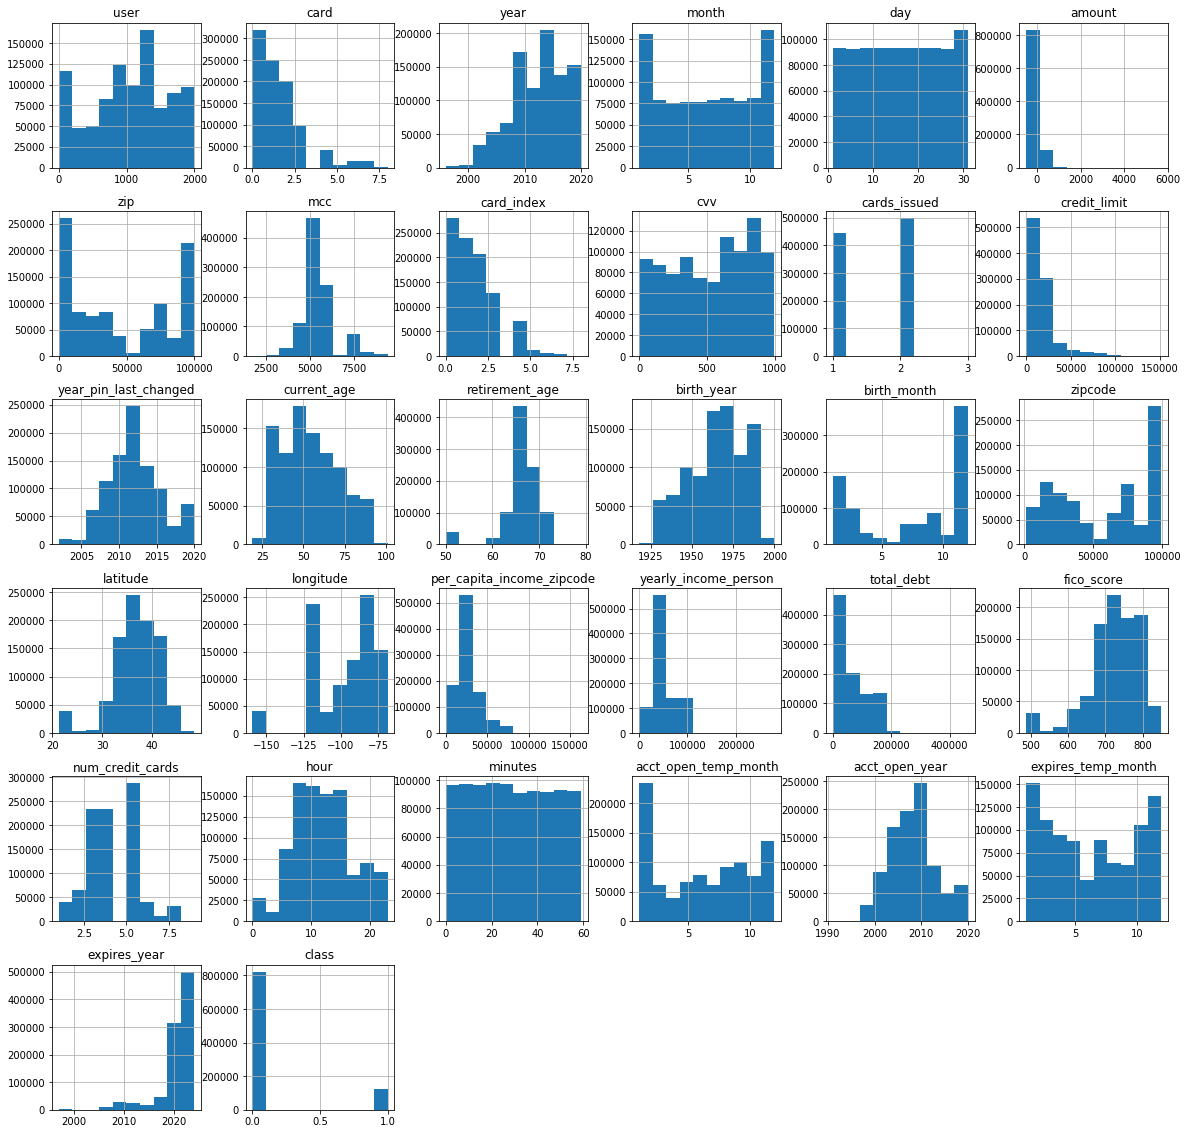

In [61]:
df_joined_tables.hist(figsize = (20,20))
plt.show()

### Fraudulent transactions over the years

### Fraudulent transaction base on type of cards

# Creating Dummy Variables and One Hot encoding

In [62]:
#create dummy variables for use_chip
use_chip_dummies = pd.get_dummies(df_joined_tables.use_chip)
use_chip_dummies.head()

,Chip Transaction,Online Transaction,Swipe Transaction
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [63]:
#create dummy variables for has_chip
has_chip_dummies = pd.get_dummies(df_joined_tables.has_chip)
has_chip_dummies.head()

,NO,YES
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [64]:
#create dummy variables for gender
gender_dummies = pd.get_dummies(df_joined_tables.gender)
gender_dummies.head()

,Female,Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [65]:
#creat dummy variables for card_type
card_dummies = pd.get_dummies(df_joined_tables.card_type)
card_dummies.head()

,Credit,Debit,Debit (Prepaid)
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


In [66]:
#use_chip_dummies, has_chip_dummies merged into data frame
merge_df = pd.concat([df_joined_tables, has_chip_dummies, use_chip_dummies, gender_dummies,card_dummies ], axis='columns')
merge_df.head()

,user,card,year,month,day,amount,use_chip,merchant_name,merchant_city,merchant_state,...,NO,YES,Chip Transaction,Online Transaction,Swipe Transaction,Female,Male,Credit,Debit,Debit (Prepaid)
0,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,,...,0,1,0,1,0,1,0,1,0,0
1,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,,...,0,1,0,1,0,1,0,0,1,0
2,1963,2,2013,12,2,88.09,Online Transaction,7145736684866660022,ONLINE,,...,0,1,0,1,0,1,0,0,0,1
3,1963,2,2013,12,2,114.00,Online Transaction,1270471339275628505,ONLINE,,...,0,1,0,1,0,1,0,1,0,0
4,1963,2,2013,12,2,114.00,Online Transaction,1270471339275628505,ONLINE,,...,0,1,0,1,0,1,0,0,1,0


In [67]:
import awswrangler as wr
wr.s3.to_csv(df=merge_df, path='s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/merge_df.csv')

{'paths': ['s3://sagemaker-us-east-1-584771966647/finalproject-datasets/csv/merge_df.csv'],
 'partitions_values': {}}

In [68]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed                         -> True
ingest_create_athena_table_csv_passed                  -> True
ingest_exploration_passed                              -> False
s3_private_path_csv_card_info                          -> 's3://sagemaker-us-east-1-584771966647/finalprojec
s3_private_path_csv_credit_card_trans                  -> 's3://sagemaker-us-east-1-584771966647/finalprojec
s3_private_path_csv_user_credit_card_trans             -> 's3://sagemaker-us-east-1-584771966647/finalprojec
s3_private_path_csv_user_info                          -> 's3://sagemaker-us-east-1-584771966647/finalprojec
s3_public_path_csv_card_info                           -> 's3://finalproject-datasets/csv/card_info/'
s3_public_path_csv_credit_card_trans                   -> 's3://finalproject-datasets/csv/credit_card_trans/
s3_public_path_csv_user_credit_card_trans              -> 's3://finalproject-datasets/csv/user_credit_card_t
s3_public_pat

In [69]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [70]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>